#  Predicting the worlds offline population
##  Model Training and Evaluation 
## (XGBoost on Brazil)

In [14]:
# load libraries
import yaml
import xgboost as xgb
import pandas as pd
import numpy as np
import plotly.figure_factory as ff
import plotly.express as px
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score

In [2]:
import os
import pandas as pd

#You will need to reset this to your own working directory
os.chdir('/home/desktop3/itu')
path = os.getcwd()
print(path)

/home/desktop3/itu


In [8]:
# read in (yaml) configs
with open(path + '/conf/model_config.yaml', 'r') as conf:
    model_config = yaml.safe_load(conf)

# import data
dataset = model_config['model']['loc'] + model_config['model']['file']
dataset = pd.read_csv(dataset)
# subset for faster trial and error
#dataset = dataset.iloc[0:1000,:]

# define predictors and target
predictor   =  model_config['meta']['predictors']
target = model_config['meta']['target']

In [9]:
dataset.columns

Index(['source_school_id', 'latitude', 'longitude', 'school_location',
       'geometry', 'target', 'mean_ghm', 'mean_avg_rad', 'change_year_avg_rad',
       'slope_year_avg_rad', 'change_month_avg_rad', 'slope_month_avg_rad',
       'mean_cf_cvg', 'change_year_cf_cvg', 'slope_year_cf_cvg',
       'change_month_cf_cvg', 'slope_month_cf_cvg', 'mean_NDVI',
       'change_year_NDVI', 'slope_year_NDVI', 'change_month_NDVI',
       'slope_month_NDVI', 'estimate_dau', 'estimate_mau', 'estimate_ready',
       'range', 'avg_d_kbps', 'avg_u_kbps', 'population'],
      dtype='object')

In [16]:
# prepare data
X = dataset[predictor]
y = dataset[target]
print('X Shape:', X.shape)
print('y Shape:', y.shape)
   
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = model_config['parameter']['test_size'], 
                                                    random_state = 42)

print('X_train, X_test, y_train, y_test shapes:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print("size of training dataset = ", len(X_train))
print("size of test dataset = ", len(X_test))

X Shape: (11732, 12)
y Shape: (11732, 1)
X_train, X_test, y_train, y_test shapes: (8212, 12) (3520, 12) (8212, 1) (3520, 1)
size of training dataset =  8212
size of test dataset =  3520


In [17]:
from sklearn.metrics import make_scorer

# customized evaluation function for CV
# Focusing on the predictions that are below .3
def custom_eval_metric(y_true, y_pred):
    errors_low=abs(y_pred[y_pred<model_config['parameter']['threshold']] - np.asarray(y_true[y_pred<model_config['parameter']['threshold']]).flatten())
    return np.mean(errors_low)

custom_scorer = make_scorer(custom_eval_metric, greater_is_better = False)

In [19]:
# configure cv
cv_inner = KFold(n_splits = 3, shuffle=True, random_state=123)

# define parameter space
parameters = {"n_estimators": model_config['parameter']['XGBoost']['n_estimators'],
                "max_depth": model_config['parameter']['XGBoost']['max_depth'],
                "eta": model_config['parameter']['XGBoost']['eta'] }

# define the model
model = xgb.XGBRegressor(random_state = 1234)

# define grid search
#search = GridSearchCV(model, parameters, scoring = custom_scorer, cv = cv_inner, refit = True, verbose = 2)
# define grid search
search = RandomizedSearchCV(model, parameters, scoring = custom_scorer, cv = cv_inner, refit = True, verbose = 2, n_iter=model_config['parameter']['iterations'])

# execute search
result = search.fit(X_train, y_train)

# get best perf model
best_model = result.best_estimator_

# evaluate the model
#acc = accuracy_score(y_test, yhat)

# store the result
#outer_results.append(acc)

# report progress
print('est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))

#print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END .............eta=0.2, max_depth=9, n_estimators=350; total time=   2.4s
[CV] END .............eta=0.2, max_depth=9, n_estimators=350; total time=   2.3s
[CV] END .............eta=0.2, max_depth=9, n_estimators=350; total time=   2.7s
[CV] END ............eta=0.2, max_depth=12, n_estimators=550; total time=   2.5s
[CV] END ............eta=0.2, max_depth=12, n_estimators=550; total time=   2.3s
[CV] END ............eta=0.2, max_depth=12, n_estimators=550; total time=   2.2s
[CV] END .............eta=0.2, max_depth=9, n_estimators=550; total time=   2.9s
[CV] END .............eta=0.2, max_depth=9, n_estimators=550; total time=   2.9s
[CV] END .............eta=0.2, max_depth=9, n_estimators=550; total time=   3.5s
est=-0.077, cfg={'n_estimators': 550, 'max_depth': 12, 'eta': 0.2}


In [20]:
# best results
best_parameter = search.best_params_
print(best_parameter)

{'n_estimators': 550, 'max_depth': 12, 'eta': 0.2}


In [22]:
# choose best parameter from tuning
best_parameter = search.best_params_

print("#####################################################")
print("choose best parameter from tuning: ", best_parameter)
print("#####################################################")

model = xgb.XGBRegressor(random_state = 42, n_estimators = best_parameter['n_estimators'],
                            max_depth = best_parameter['max_depth'],
                              eta = best_parameter['eta'])

# find best parameters
model.fit(X_train, y_train)

#####################################################
choose best parameter from tuning:  {'n_estimators': 550, 'max_depth': 12, 'eta': 0.2}
#####################################################


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.2, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.200000003, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=550, n_jobs=16, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
# predict holdout
pred = model.predict(X_test)

# mean absolute error as KPI
errors = abs(pred - y_test.iloc[:,0].to_numpy())

In [33]:
avg_error = np.mean(errors)

#Low tail error
errors_low = abs(pred[pred<model_config['parameter']['threshold']] - np.asarray(y_test[pred<model_config['parameter']['threshold']]).flatten())

#Low tail error
errors_low_ytest = abs(pred[np.asarray(y_test).flatten()<model_config['parameter']['threshold']] - np.asarray(y_test[np.asarray(y_test).flatten()<model_config['parameter']['threshold']]).flatten())

#avg error
avg_error_low = np.mean(errors_low)


#avg error
avg_error_low_ytest = np.mean(errors_low_ytest)

#standard deviation
stan_dev_low= np.std(errors_low)

print('avg error: ', avg_error)
print('Mean lower error: ', avg_error_low)
print('Mean ytest lower error: ', avg_error_low_ytest)
print('Standard Dev of Low Error: ', stan_dev_low)

avg error:  0.06501446586869881
Mean lower error:  0.06935449611107833
Mean ytest lower error:  0.18024554747740149
Standard Dev of Low Error:  0.11150307774735672


In [25]:
y = y_test.iloc[:,0].to_numpy()
y_pred = pred

fig = px.scatter(x=y, y=y_pred, labels={'x': 'ground truth', 'y': 'prediction'}, 
                 title = 'Comparison between predictions and reality',
                 template = 'plotly_dark')
fig.update_traces(marker=dict(size=3, 
                              color=((abs(y-y_pred) < 0.15).astype('int')),
                              
                              colorscale=[[0, '#FAED27'],[1, '#98FB98']])
                             )
fig.add_shape(
    type="line", line=dict(dash='dash'),
    x0=y.min(), y0=y.min(),
    x1=y.max(), y1=y.max()
)
fig.show()

In [26]:
y_pred

array([0.65621364, 0.7016865 , 0.8699198 , ..., 0.6149589 , 0.7082855 ,
       0.9268507 ], dtype=float32)

In [28]:
importance = pd.DataFrame(
    {"Feature": X.columns, "Importance": model.feature_importances_}
).sort_values("Importance")

In [29]:
importance

Feature  Importance
0            avg_d_kbps    0.016661
1            avg_u_kbps    0.026805
11           population    0.051955
2              mean_ghm    0.053449
5    slope_year_avg_rad    0.084098
4           mean_cf_cvg    0.089150
6   slope_month_avg_rad    0.089554
10      slope_year_NDVI    0.093762
3          mean_avg_rad    0.095396
9             mean_NDVI    0.096505
8    slope_month_cf_cvg    0.104981
7          estimate_mau    0.197684

<AxesSubplot:title={'center':'Feature Importances'}>

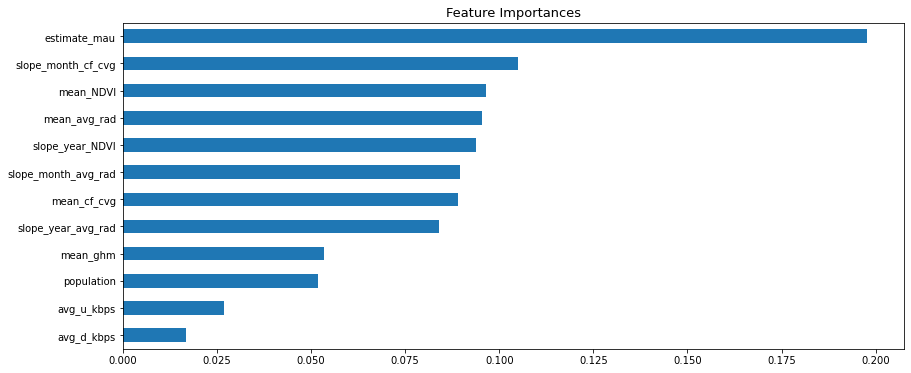

In [32]:
import matplotlib.pyplot as plt
fig,ax =plt.subplots(1, figsize=(14,6))

# add a title and annotation
ax.set_title('Feature Importances', fontdict={'fontsize': '13', 'fontweight' : '3'})

(pd.Series(model.feature_importances_, index=X.columns)
   .nsmallest(12).plot(kind='barh'))